<a href="https://colab.research.google.com/github/kozoB/vit-pathmnist-classifier/blob/main/ViT_Medical_Imaging_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import importlib.util
import subprocess
import sys

# Install medmnist only if not already installed
if importlib.util.find_spec("medmnist") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "medmnist"])

import medmnist
from medmnist import PathMNIST
from medmnist import INFO

from torchvision import transforms
from torch.utils.data import DataLoader

# Load Dataset

In [2]:
data_flag = 'pathmnist'
download = True

# Load metadata
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Data Preprocessing

In [3]:
# Resize to 224x224 for ViT input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [4]:
from torch.utils.data import Dataset

class TransformedMedMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

In [5]:
train_dataset_raw = DataClass(split='train', download=download)
test_dataset_raw = DataClass(split='test', download=download)

train_dataset = TransformedMedMNIST(train_dataset_raw, transform=transform)
test_dataset = TransformedMedMNIST(test_dataset_raw, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 206M/206M [02:46<00:00, 1.23MB/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


# Load Model

In [6]:
from transformers import ViTForImageClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    "facebook/deit-tiny-patch16-224",
    num_labels=9,
    ignore_mismatched_sizes=True
).to(device)

print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([9, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [7]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
!nvidia-smi

CUDA available: True
Current device: 0
Fri May 23 11:49:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             25W /   70W |     124MiB /  15360MiB |      4%      Default |
|                                         |                        |                  N/A |
+--------

In [8]:
from torch import nn
from torch.optim import AdamW

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-5)

# Model Training

In [9]:
from tqdm import tqdm

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.squeeze().to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.squeeze().to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            total_loss += loss.item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

In [10]:
EPOCHS = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1: Train Loss = 0.1952, Train Acc = 0.9399, Val Loss = 0.2424, Val Acc = 0.9220
Epoch 2: Train Loss = 0.0675, Train Acc = 0.9790, Val Loss = 0.2537, Val Acc = 0.9316
Epoch 3: Train Loss = 0.0430, Train Acc = 0.9865, Val Loss = 0.2800, Val Acc = 0.9247
Epoch 4: Train Loss = 0.0310, Train Acc = 0.9902, Val Loss = 0.2393, Val Acc = 0.9327
Epoch 5: Train Loss = 0.0242, Train Acc = 0.9928, Val Loss = 0.2990, Val Acc = 0.9238


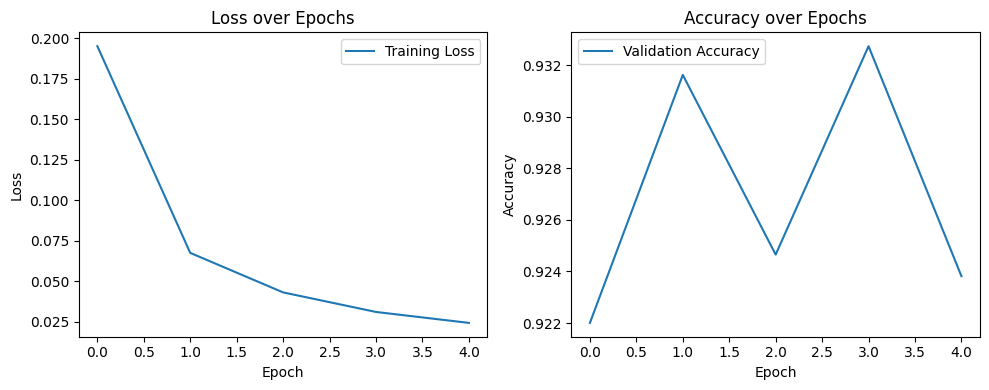

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Save Model To Drive

In [13]:
from google.colab import drive

drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Masters Degree/Deep Learning Course'

model.save_pretrained(save_path)

Mounted at /content/drive


# Load Model From Drive

In [14]:
from google.colab import drive
from transformers import ViTForImageClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')
load_path = '/content/drive/MyDrive/Masters Degree/Deep Learning Course'

model = ViTForImageClassification.from_pretrained(load_path)
model.to(device)  # Move to GPU if available

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

# Evaluations

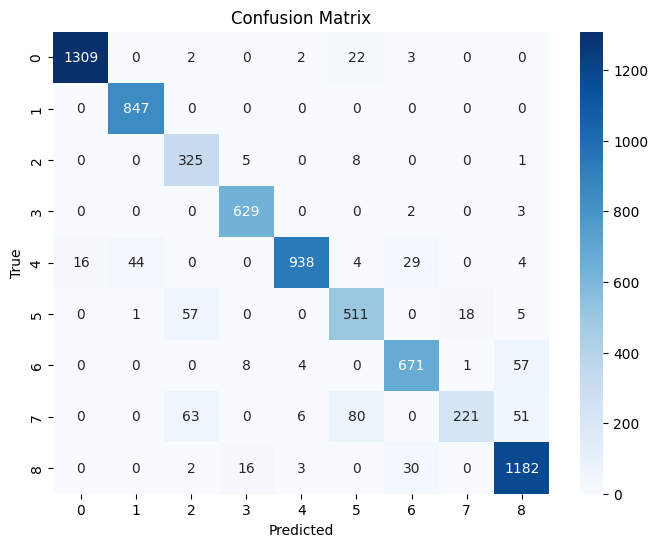

              precision    recall  f1-score   support

           0     0.9879    0.9783    0.9831      1338
           1     0.9496    1.0000    0.9741       847
           2     0.7238    0.9587    0.8249       339
           3     0.9559    0.9921    0.9737       634
           4     0.9843    0.9063    0.9437      1035
           5     0.8176    0.8632    0.8398       592
           6     0.9129    0.9055    0.9092       741
           7     0.9208    0.5249    0.6687       421
           8     0.9071    0.9586    0.9322      1233

    accuracy                         0.9238      7180
   macro avg     0.9067    0.8986    0.8944      7180
weighted avg     0.9280    0.9238    0.9214      7180



In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def get_predictions(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.squeeze().cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

preds, true_labels = get_predictions(model, test_loader)

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# F1, Precision, Recall, etc.
print(classification_report(true_labels, preds, digits=4))

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# One-hot encode true labels
y_true_bin = label_binarize(true_labels, classes=list(range(9)))  # For 9 classes

# Get probabilities instead of hard predictions
model.eval()
probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        logits = model(images).logits
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        probs.extend(prob)

# Compute ROC-AUC per class (macro-avg)
roc_auc = roc_auc_score(y_true_bin, np.array(probs), average="macro", multi_class="ovr")
print(f"Macro ROC-AUC: {roc_auc:.4f}")

Macro ROC-AUC: 0.9935
